<a href="https://colab.research.google.com/github/adnaks97/Natural-Language-Inference/blob/master/BioBERT_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.6-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 1.3MB 4.7MB/s 
     |████████████████████████████████| 890kB 16.4MB/s 
     |████████████████████████████████| 2.9MB 45.3MB/s 
     |████████████████████████████████| 1.1MB 40.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=1a9a4be2ccb24057817c98d1b44f7184f8a0f4836ad0c57267a4348e494c8fa7
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 133.2MB 96kB/s 
     |████████████████████████████████| 61kB 3.9MB/s 
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12


In [3]:
from google.colab import drive
import os
from getpass import getpass
import urllib
drive.mount('/content/drive')
# If repo already cloned in drive
os.chdir('drive/My Drive/Natural-Language-Inference')

Mounted at /content/drive


In [4]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer, AdamW, BertForSequenceClassification, BertTokenizer
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import get_linear_schedule_with_warmup
from collections import defaultdict

In [5]:
model_name = 'emilyalsentzer/Bio_ClinicalBERT' # 'bert-base-uncased
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, force_download=False)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

In [6]:
train_df = pd.read_csv('Data/mli_train_v1.csv')
val_df = pd.read_csv('Data/mli_dev_v1.csv')

In [7]:
train_pre, train_hyp, train_labels = train_df['premise'].tolist(), train_df['hypothesis'].tolist(), train_df['gold_label'].tolist()
val_pre, val_hyp, val_labels = val_df['premise'].tolist(), val_df['hypothesis'].tolist(), val_df['gold_label'].tolist()

In [8]:
le = LabelEncoder()
le.fit(train_labels)
train_labels = le.transform(train_labels)
val_labels = le.transform(val_labels)

In [9]:
for pre, hyp, encoded_label, label in zip(train_pre[:10], train_hyp[:10], train_labels[:10], le.inverse_transform(train_labels[:10])):
  print(pre + ' ||||| ' + hyp + ' <=======> ' + str(encoded_label) + ' = '+ str(label))

labs were notable for cr 1.7 (baseline 0.5 per old records) and lactate 2.4. ||||| patient has elevated cr <=======> 1 = entailment
labs were notable for cr 1.7 (baseline 0.5 per old records) and lactate 2.4. ||||| patient has normal cr <=======> 0 = contradiction
labs were notable for cr 1.7 (baseline 0.5 per old records) and lactate 2.4. ||||| patient has elevated bun <=======> 2 = neutral
nystagmus and twiching of r arm was noted. ||||| the patient had abnormal neuro exam. <=======> 1 = entailment
nystagmus and twiching of r arm was noted. ||||| the patient has a normal neuro exam. <=======> 0 = contradiction
nystagmus and twiching of r arm was noted. ||||| the patient has an acute stroke. <=======> 2 = neutral
the patient was seen by his primary care physician after he had complained of a one-week history of dyspnea on exertion and jaw tightness. ||||| the patient has symptoms of a chf exacerbation. <=======> 1 = entailment
the patient was seen by his primary care physician after h

In [10]:
for pre, hyp, encoded_label, label in zip(val_pre[:10], val_hyp[:10], val_labels[:10], le.inverse_transform(val_labels[:10])):
  print(pre + ' ||||| ' + hyp + ' <=======> ' + str(encoded_label) + ' = '+ str(label))

no history of blood clots or dvts, has never had chest pain prior to one week ago. ||||| patient has angina <=======> 1 = entailment
no history of blood clots or dvts, has never had chest pain prior to one week ago. ||||| patient has had multiple pes <=======> 0 = contradiction
no history of blood clots or dvts, has never had chest pain prior to one week ago. ||||| patient has cad <=======> 2 = neutral
over the past week pta he has been more somnolent and difficult to arrouse. . ||||| he has been less alert over the past week <=======> 1 = entailment
over the past week pta he has been more somnolent and difficult to arrouse. . ||||| over the past week he has been alert and oriented <=======> 0 = contradiction
over the past week pta he has been more somnolent and difficult to arrouse. . ||||| he is disorientated and complains of weakness <=======> 2 = neutral
copd/asthma: spirometry (4/3393) fvc 2.48 (67%), fev1 1.96 (68%), fev1/fvc 101%, dlco (3/3392) 51%, lung vol (3/3392): tlc 64%, f

In [11]:
token_lens = []

for txt in train_hyp:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


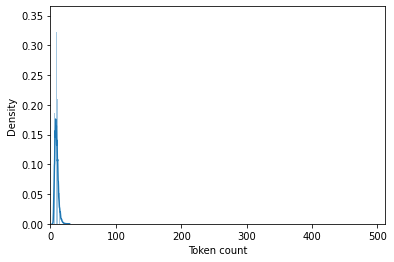

In [12]:
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [13]:
max(token_lens)

28

In [14]:
(tokenizer.encode_plus("This is sentence two", "This is sentence 2 of a very mauch lonegr length lets see", max_length=30, padding='max_length'))

{'input_ids': [101, 1142, 1110, 5650, 1160, 102, 1142, 1110, 5650, 123, 1104, 170, 1304, 12477, 9827, 14936, 1403, 1197, 2251, 11446, 1267, 102, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]}

In [15]:
enc = tokenizer.encode_plus("This is sentence one of lenght approx. 23", "This is sentence two", max_length=5, padding='max_length')

In [16]:
len(enc['input_ids'])

18

In [17]:
tokenizer.convert_ids_to_tokens(enc['input_ids'])

['[CLS]',
 'this',
 'is',
 'sentence',
 'one',
 'of',
 'le',
 '##ng',
 '##ht',
 'approx',
 '.',
 '23',
 '[SEP]',
 'this',
 'is',
 'sentence',
 'two',
 '[SEP]']

In [18]:
class MedNLIDataset(torch.utils.data.Dataset):
  def __init__(self, premise_sent, hypothesis_sent, labels, tokenizer, max_len=512):
    self.premise_sent = premise_sent
    self.hypothesis_sent = hypothesis_sent
    self.labels = labels
    self.max_len = max_len
  
  def __getitem__(self, idx):
    premise = self.premise_sent[idx]
    hypothesis = self.hypothesis_sent[idx]
    label = self.labels[idx]
    encoding = tokenizer.encode_plus(premise, hypothesis, add_special_tokens=True, return_token_type_ids=True, return_attention_mask=True, max_length=self.max_len, padding='max_length', truncation=True, return_tensors='pt')
    #print('After encoding: ', encoding)
    #print("Processing: ", idx)
    #print(encoding['input_ids'].shape, encoding['attention_mask'].shape, encoding['token_type_ids'].shape)
    data = {
      'premise': premise,
      'hypothesis': hypothesis,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'token_type_ids': encoding['token_type_ids'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }
    return data

  def __len__(self):
    return len(self.labels)

In [19]:
def create_data_loader(premise_sent, hypothesis_sent, labels, tokenizer, batch_size, max_len):
  ds = MedNLIDataset(
    premise_sent=premise_sent,
    hypothesis_sent=hypothesis_sent,
    labels=labels,
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
    #collate_fn=lambda x:x
  )

In [20]:
BATCH_SIZE=16
MAX_LEN = 160

In [21]:
train_data_loader = create_data_loader(train_pre, train_hyp, train_labels, tokenizer, BATCH_SIZE, MAX_LEN)
val_data_loader = create_data_loader(val_pre, val_hyp, val_labels, tokenizer, BATCH_SIZE, MAX_LEN)

In [22]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['premise', 'hypothesis', 'input_ids', 'attention_mask', 'token_type_ids', 'labels'])

In [23]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [24]:
import torch_xla
import torch_xla.core.xla_model as xm
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#DEVICE = xm.xla_device()
DEVICE

'cuda:0'

In [25]:
model.to(DEVICE)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [26]:
input_ids = data['input_ids'].to(DEVICE)
attention_mask = data['attention_mask'].to(DEVICE)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [27]:
from torch.nn.functional import softmax
model.aux_logits=False

In [28]:
F.softmax(model(input_ids, attention_mask)[0], dim=1)

tensor([[0.1950, 0.3523, 0.4527],
        [0.1953, 0.3538, 0.4509],
        [0.2077, 0.3650, 0.4273],
        [0.2706, 0.3847, 0.3447],
        [0.2837, 0.4148, 0.3015],
        [0.2754, 0.4048, 0.3198],
        [0.2473, 0.3747, 0.3780],
        [0.2508, 0.3737, 0.3755],
        [0.2453, 0.3821, 0.3726],
        [0.2424, 0.4080, 0.3496],
        [0.2384, 0.3927, 0.3689],
        [0.2408, 0.3954, 0.3638],
        [0.2474, 0.4085, 0.3441],
        [0.2612, 0.4355, 0.3033],
        [0.2537, 0.4063, 0.3400],
        [0.2405, 0.3952, 0.3643]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## Training

In [29]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=100,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(DEVICE)

In [30]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for i,d in enumerate(data_loader):
    print(i)
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["labels"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )[0]

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [31]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )[0]
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [1]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    DEVICE, 
    scheduler, 
    len(train_labels)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    DEVICE, 
    len(val_labels)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), './results/best_model_state.bin')
    best_accuracy = val_acc

NameError: ignored